# Support Vector Machines

In [16]:
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC, SVR, LinearSVC

# Other
import pandas as pd
import numpy as np

from plot_classifier import plot_classifier
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from plot_classifier import plot_classifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

- Similarity-based algorithm.
- Superficially, SVMs are more like weighted $k$-NNs. $k$-NNs are the Supervised Learning cousin of K-means.
    - The decision boundary is defined by **a set of positive and negative examples** and **their weights** together with **their similarity measure**. 
    - A test example is a positive if on average it looks more like positive examples than the negative examples. 

- What makes SVMs special is that they **only remember key examples (support vectors)**. So it's more efficient than other similarity-based algorithms.

- SVMs use a similarity metric which is called a "kernel" in SVM land. A popular kernel is Radial Basis Functions (RBFs) which we will use today. - More on this towards the end
- https://en.wikipedia.org/wiki/Radial_basis_function_kernel

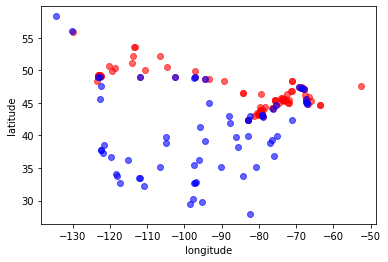

In [17]:
cities_df = pd.read_csv('../data/canada_usa_cities.csv')
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
canada = train_df.query('country == "Canada"')
usa = train_df.query('country == "USA"')
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
plt.ylabel("latitude")
plt.xlabel("longitude");

In [18]:
# split into training/validation and testing set
X_train, y_train = train_df.drop(columns=['country']), train_df['country']
X_test, y_test = test_df.drop(columns=['country']), test_df['country']

In [19]:
from sklearn.svm import SVC

svm = SVC(gamma=0.01) # Ignore gamma for now
svm.fit(X_train, y_train)
print("Train scores: ", round(svm.score(X_train, y_train), 4))
print("Test scores: ", round(svm.score(X_test, y_test), 4))

Train scores:  0.8383
Test scores:  0.8333


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


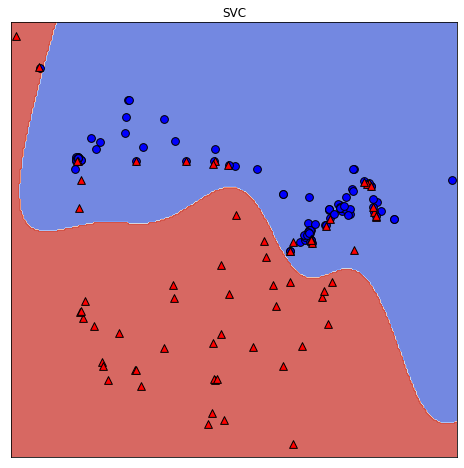

In [20]:
# You can think of SVM with radial basis function kernel as "smooth KNN"
plt.figure(figsize=(8, 8))
plt.title("SVC")
plot_classifier(X_train, y_train, svm, ax=plt.gca());

#### Support vectors 

- Each training example either is or isn't a "support vector".
  - This gets decided during `fit`.

- **Main insight: the decision boundary only depends on the support vectors.**

- Let's look at the support vectors. 


We want a hyperplane that separates positive examples from negative ones with the **largest margin**. 

If the margin or decision boundary is large, it contributes to a better generalization, that is how well the model will classify new examples in the future. 

<img src="../images/svmplanes.PNG" style="width: 700px;"/>


That’s how Support Vector Machines work. This particular version of the algorithm builds the so-called linear model. It’s called linear because the decision boundary is a straight line (or a plane, or a hyperplane).

In [28]:
# demo with a synthetic data set
n = 20
X = np.random.randn(n,2)
y = np.random.choice((-1,+1),size=n)
X[y>0,0] -= 2
X[y>0,1] += 2

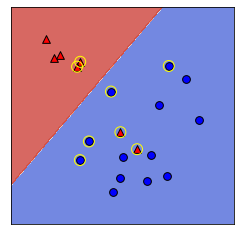

In [29]:
svm = SVC(kernel="linear", C=1e6) # ignore the C=1e6 for now
svm.fit(X,y)

plt.figure(figsize=(4,4))
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

- The support vectors (SVs) are shown in yellow.
- These are the example that "support" the boundary. 

Below: let's try removing all other examples, keeping only the SVs.

In [30]:
sv = svm.support_
not_sv = list(set(range(n)) - set(sv))

[[-0.7929497   0.61829873]]
[[-0.79298144  0.61832953]]
The coefficients are the same!


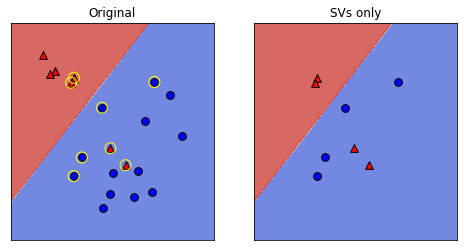

In [31]:
# remove all non-support vectors
X3 = np.delete(X,not_sv,0)
y3 = np.delete(y,not_sv,0)

svm3 = SVC(kernel="linear", C=1e6)
svm3.fit(X3,y3)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");
plt.subplot(1,2,2)
plot_classifier(X3,y3,svm3, ax=plt.gca(), lims=(X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1))
plt.title("SVs only");

print(svm.coef_)
print(svm3.coef_)
print("The coefficients are the same!")

[[-0.7929497   0.61829873]]
[[-0.72127645  0.87973366]]


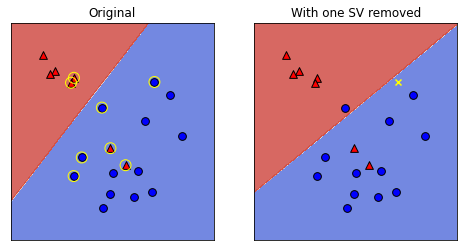

In [32]:
# remove a support vector
X2 = np.delete(X,sv[0],0)
y2 = np.delete(y,sv[0],0)

svm2 = SVC(kernel="linear", C=1e6)
svm2.fit(X2,y2);

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");

plt.subplot(1,2,2)
plot_classifier(X2,y2,svm2, ax=plt.gca())
plt.scatter(svm.support_vectors_[0,0], svm.support_vectors_[0,1], marker="x", c="yellow")
plt.title("With one SV removed");

print(svm.coef_)
print(svm2.coef_)

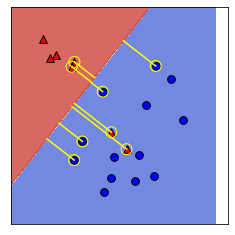

In [33]:
plt.figure()
plot_classifier(X, y, svm, ax=plt.gca());
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis('equal');
plt.axis('square');

def SV_proj(svm):
    v = svm.support_vectors_
    s = np.array([svm.coef_.flatten()[1], -svm.coef_.flatten()[0]])
    w = svm.coef_
    return (v@s[:,None])/(s@s) * s - w/(w@w.T)*svm.intercept_
proj = SV_proj(svm)

for i in range(len(proj)):
    p = proj[i]
    sv = svm.support_vectors_[i]
    plt.plot((p[0],sv[0]),(p[1],sv[1]), 'yellow')

### Hyperparameters of SVM 

- Key hyperparameters of `rbf` (radial basis function) SVM are
    - `gamma`
    - `C`
    
- We are not equipped to understand the meaning of these parameters at this point but you are expected to describe their relation to the fundamental tradeoff. 

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

### Relation of `gamma` and the fundamental trade-off
- `gamma` controls the distance of influence of a single training point. The larger the gamma, the smaller the raidus of influence for points to be considered in the same group. The lower this value, the larger the influence. 
- `gamma` is a hyper parameter of RBF only.
- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ more complex $\rightarrow$ can lead to overfitting
  - smaller `gamma` $\rightarrow$ less complex $\rightarrow$ can lead to underfitting
  
### Relation of `C` and the fundamental trade-off
- `C` adds a penalty for each misclassified point. The smaller C is, the smaller the penalty and the larger the margin. In other words, increase the bias of the model for decreased variance. In other other words, lower C equates to more generalized model.
- `C` _also_ affects the fundamental tradeoff
    - larger `C` $\rightarrow$ more complex $\rightarrow$ can lead to overfitting
    - smaller `C` $\rightarrow$ less complex $\rightarrow$ can lead to underfitting
    
**C helps us deal with Noise**

### The Kernel Trick

1. What if there’s noise in the data and no hyperplane can perfectly separate positive examples from negative ones?
2. What if the data cannot be separated using a plane, but could be separated by a higher-order polynomial?

SVM can also incorporate kernels that can make the decision boundary arbitrarily non-linear. In some cases, it could be impossible to perfectly separate the two groups of points because of noise in the data, errors of labeling, or outliers. 

You can see both situations in the next figure. In the left case, the data could be separated by a straight line if not for the noise (outliers or examples with wrong labels). 

In the right case, the decision boundary is a circle and not a straight line.

<img src="../images/img2.png" alt="Drawing" style="width: 500px;"/>



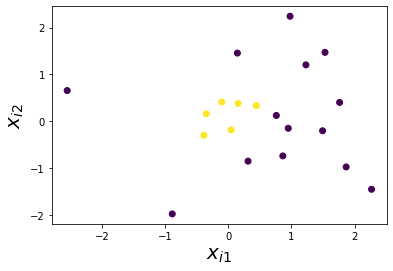

In [34]:
n = 20
d = 2
np.random.seed(0)
X = np.random.randn(n,d)
y = np.sum(X**2,axis=1) < 0.4

plt.scatter(X[:,0], X[:,1], c=y);
plt.xlabel("$x_{i1}$", fontsize=20);
plt.ylabel("$x_{i2}$", fontsize=20);

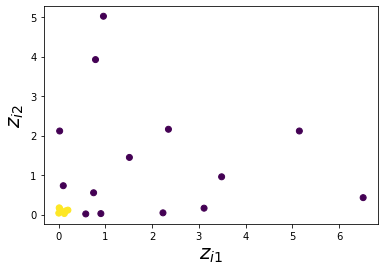

In [35]:
Z = X**2

plt.scatter(Z[:,0], Z[:,1], c=y);
plt.xlabel("$z_{i1}$", fontsize=20);
plt.ylabel("$z_{i2}$", fontsize=20);

Training accuracy 1.0


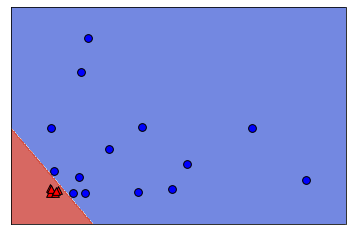

In [36]:
svm = SVC(kernel="linear", C=100)
svm.fit(Z,y)

plot_classifier(Z,y,svm)

print("Training accuracy", svm.score(Z,y))

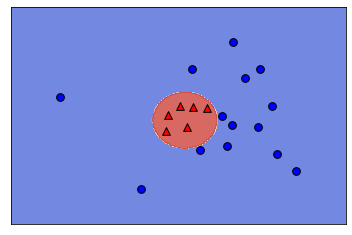

In [37]:
plot_classifier(X, y, svm, transformation=lambda X: X**2);